In [152]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
from itertools import chain
from ddeint import ddeint

import sys
sys.path.append('..')
from canard_explosions.FH_N import FH_N

In [153]:
def FH_N(t, y, a=5, tau_n=60, I=-4.2):
    v, n = y
    dvdt = v - (v**3) / 3 - n + I
    dndt = (a * v - n) / tau_n

    return np.array([dvdt, dndt])

## Diffusive Coupling Between Neurons

$$\text{neuron-coupled-term}_i = \sum_{j} g_{ij} (v_j - v_i)$$

In [154]:
# def f(u: np.array,v: np.array, g_c, u_syn):
#     return u - 1/3*np.power(u,3) + v + g_c * np.tanh(u - u_syn)

# def g(u: np.array,v: np.array, a, b, c):
#     return (a - b*v - u) / c

def FHN_system(t:float, y:np.array, L:np.array, d1:float, d2:float, g_c:float = 0.25, u_syn:float = 0.8, a:float = 0.7, b:float = 0.8, c:float = 3):
    u = y[0::2]
    v = y[1::2]

    u_coupled_term = d1*L@u
    v_coupled_term = d2*L@v

    dudt = u - 1/3*np.power(u,3) + v + g_c * np.tanh(u - u_syn) + u_coupled_term
    dvdt = (a - b*v - u) / c + v_coupled_term

    dsystemdt = np.array( list(chain.from_iterable(zip(dudt, dvdt))) )

    return dsystemdt

def FHN_system_delay(t:float, y:np.array, d:float, L:np.array, d1:float = 1, d2:float = 1, g_c:float = 0.25, u_syn:float = 0.8, a:float = 0.7, b:float = 0.8, c:float = 3):
    u = y[0::2]
    v = y[1::2]

    u_coupled_term = d1*L@u
    v_coupled_term = d2*L@v

    u_delay = y[0::2, int(t-d)]

    dudt = u - 1/3*np.power(u,3) + v + g_c * np.tanh(u_delay - u_syn) + u_coupled_term
    dvdt = (a - b*v - u) / c + v_coupled_term

    dsystemdt = np.array( list(chain.from_iterable(zip(dudt, dvdt))) )

    return dsystemdt

In [155]:
# Defining our adjacency matrix A
# A = np.array([[0.2,0.9],
#               [0.5,0.2],])
N = 2
A = np.random.rand(N,N)

L = A
for i in range(0,A.shape[0]):
    L[i,i] = -sum(A[i,:])

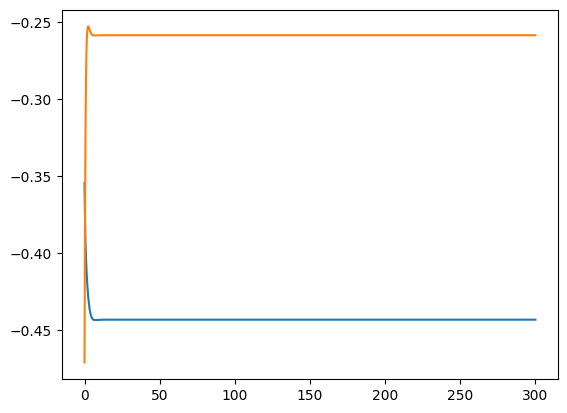

In [156]:
# y0 = [2,-0.5,2,-0.6]

rand_u0 = np.random.rand(N) + 1
rand_v0 = 0.5*(np.random.rand(N) - 1)

rand_y0 = list(chain.from_iterable(zip(rand_u0, rand_v0)))

soln = solve_ivp(lambda t,y: FHN_system(t,y,L=L,d1=0.5,d2=1), t_span=[0,300], y0=rand_y0, rtol=1e-8, atol=1e-6)
plt.plot(soln.t, soln.y[1])
plt.plot(soln.t, soln.y[3])
plt.show()

In [157]:
def make_FHN_system(L: np.array, d1: float, d2: float, tau: float, 
                    g_c: float = 0.6, u_syn: float = 0.8, a: float = 0.7, 
                    b: float = 0.8, c: float = 3):
    def FHN_system(Y, t):
        y_now = Y(t)
        y_delay = Y(t - tau)

        u = y_now[0::2]
        v = y_now[1::2]

        u_delay = y_delay[0::2]  # Only delay u, not v

        u_coupled_term = d1 * L @ u
        v_coupled_term = d2 * L @ v

        dudt = u - (1/3) * np.power(u, 3) + v + g_c * np.tanh(u_delay - u_syn) + u_coupled_term
        dvdt = (a - b * v - u) / c + v_coupled_term

        dsystemdt = np.array(list(chain.from_iterable(zip(dudt, dvdt))))
        return dsystemdt

    return FHN_system


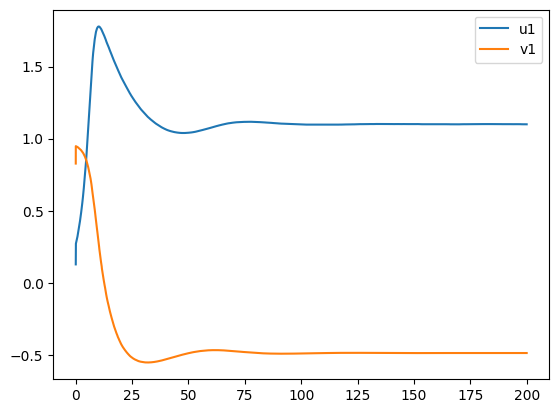

In [158]:
from ddeint import ddeint

# Example Laplacian for 2 neurons
# L = np.array([[1, -1], [-1, 1]])
d1 = 0.1
d2 = 0.05
tau = 100.0

# Create the system
FHN = make_FHN_system(L, d1, d2, tau)

# History function (for t <= 0)
def history(t):
    rand_u0 = np.random.rand(N)
    rand_v0 = 1 + 0.5*(np.random.rand(N) - 1)

    rand_y0= np.zeros(N*2)
    rand_y0[0::2] = rand_u0
    rand_y0[1::2] = rand_v0

    return rand_y0

# Time grid
tt = np.linspace(0, 200, 10000)

# Solve
sol = ddeint(FHN, history, tt)

# Plot
import matplotlib.pyplot as plt
plt.plot(tt, sol[:,0], label="u1")
plt.plot(tt, sol[:,1], label="v1")
# plt.plot(tt, sol[:,2], label="u2")
# plt.plot(tt, sol[:,3], label="v2")
plt.legend()
plt.show()